# M.1. Treasury Debt

### DRW / UChicago Prep Course

#### Chicago, Summer 2025

Questions?
* Contact: Mark Hendricks
* hendricks@uchicago.edu

***

In [1]:
import warnings
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

# Data Source

CRSP Treasury Monthly Release
accessed via WRDS

For any given date, obtain quotes for nearly every issued Treasury.

In particular, 
* Bills, Notes, Bonds
* TIPS

In the analysis below, we exclude TIPS to focus on nominal rates.

The data set does not include Floating Rate Notes (FRNs).

In [2]:
QUOTE_DATE = '2024-04-30'

filepath_rawdata = f'../data/treasury_quotes_{QUOTE_DATE}.xlsx'
data = pd.read_excel(filepath_rawdata,sheet_name='quotes').set_index('KYTREASNO')

In [3]:
tab = format_bond_df(data.head(6))
display(tab)

tab = format_bond_df(data.tail(6))
display(tab)

,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm,public size
KYTREASNO,,,,,,,,,,,,,,
208127,bill,2024-04-30,2023-11-02,2024-05-02,0.01,nan,0.0,99.97,99.97,99.97,0.00,99.97,5.38%,nan
208162,bill,2024-04-30,2024-01-09,2024-05-07,0.02,nan,0.0,99.89,99.90,99.90,0.00,99.90,5.55%,nan
208138,bill,2024-04-30,2023-11-09,2024-05-09,0.02,nan,0.0,99.87,99.87,99.87,0.00,99.87,5.39%,nan
208163,bill,2024-04-30,2024-01-16,2024-05-14,0.04,nan,0.0,99.79,99.79,99.79,0.00,99.79,5.44%,nan
206741,note,2024-04-30,2014-05-15,2024-05-15,0.04,0.92,2.5,99.88,99.91,99.89,1.15,101.04,5.08%,6e+10
207714,note,2024-04-30,2021-05-15,2024-05-15,0.04,0.92,0.25,99.80,99.80,99.80,0.11,99.92,5.17%,5e+10


,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm,public size
KYTREASNO,,,,,,,,,,,,,,
208020,TIPS note,2024-04-30,2023-02-15,2053-02-15,28.80,0.00,1.5,80.97,81.23,81.10,0.00,81.10,nan%,2e+10
208062,bond,2024-04-30,2023-05-15,2053-05-15,29.04,0.92,3.6,81.73,81.74,81.73,1.66,83.40,4.80%,6e+10
208107,bond,2024-04-30,2023-08-15,2053-08-15,29.29,0.41,4.1,89.54,89.61,89.57,0.85,90.42,4.79%,6e+10
208149,bond,2024-04-30,2023-11-15,2053-11-15,29.54,0.92,4.8,99.43,99.50,99.46,2.18,101.64,4.78%,7e+10
208191,TIPS note,2024-04-30,2024-02-15,2054-02-15,29.80,0.00,2.1,93.85,94.14,94.00,0.00,94.00,nan%,9e+09
208178,bond,2024-04-30,2024-02-15,2054-02-15,29.80,0.41,4.2,91.52,91.58,91.55,0.88,92.42,4.78%,5e+10


# Basics of Treasuries

## Timing

These quotes are at a single point in time.

But they describe bonds covering a wide range of 
* issuance dates
* maturity dates

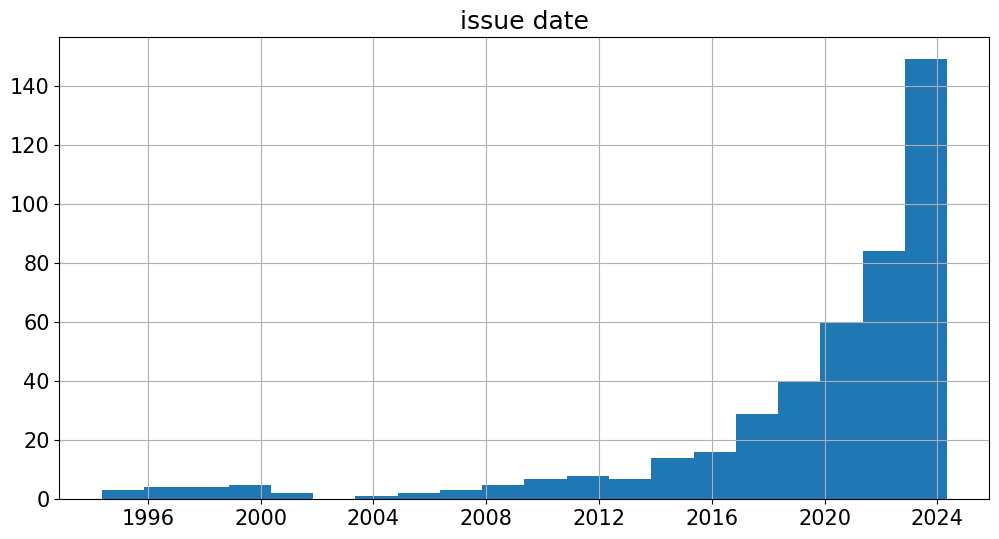

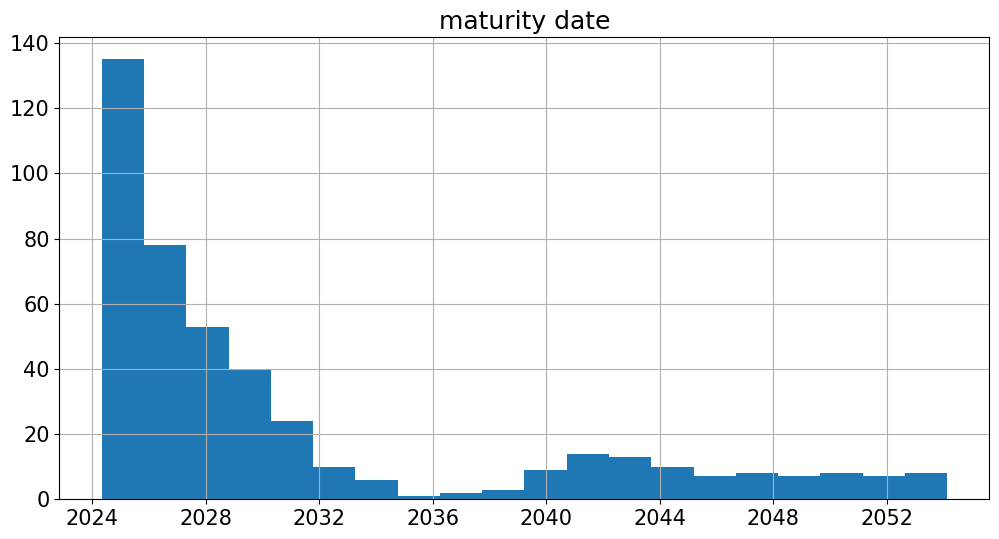

In [4]:
data.hist('issue date',bins=20)
data.hist('maturity date',bins=20)
plt.show()

## Coupon Rates

The quoted coupon is the annualized rate (per $100 face value).

It is paid semiannually.

The coupon rate is a feature set by the issuer (Treasury) at the time it is issued.
* These rates have varied widely over time.
* The Treasury sets coupons near the prevailing interest rate, (i.e., priced near par.)

In the figure below, note that coupon rates have declined over time.

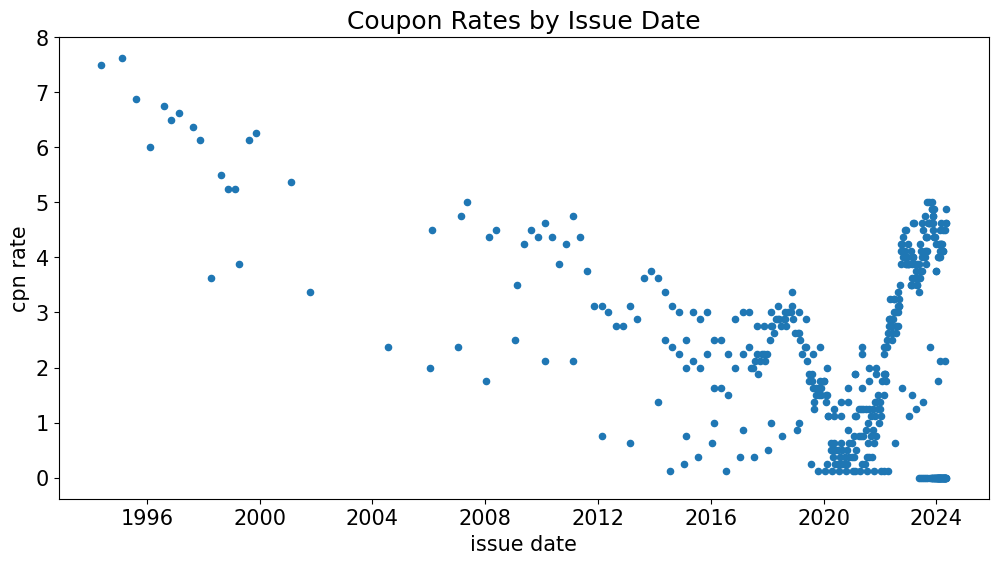

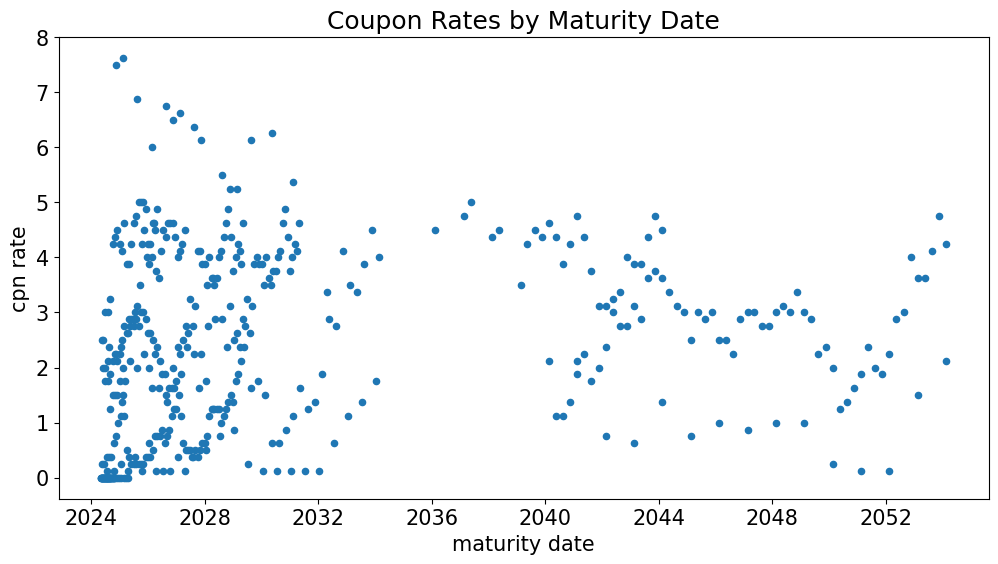

In [5]:
data.plot.scatter(x='issue date',y='cpn rate',title='Coupon Rates by Issue Date')
data.plot.scatter(x='maturity date',y='cpn rate',title='Coupon Rates by Maturity Date')
plt.show()

# Issue Types

|         | Maturity            | Coupon   | Coupon Frequency | Principal          |
|---------|---------------------|----------|------------------|--------------------|
| T-bills | 4, 8, 13, 26, 52 weeks | None     | None             | Fixed              |
| T-notes | 2, 5, 7, 10 years      | Fixed    | Semiannual       | Fixed              |
| T-bonds | 20, 30 years            | Fixed    | Semiannual       | Fixed              |
| TIPS    | 5, 10, 30 years     | Fixed    | Semiannual       | Inflation adjusted |
| FRNs    | 2 years             | Floating | Quarterly        | Fixed              |
| STRIPS  | Derived             | None     | None             | Fixed              |

Reference: 
https://www.treasurydirect.gov/indiv/research/indepth/tbills/res_tbill.htm

## Other Instruments

### TIPS

**Treasury Inflation Protected Securities** (TIPS)
- Treasury notes and bonds (no bills)
- Semiannual coupon
- Issued since 1997

**Inflation protection**

TIPS provide a hedge against inflation.
- Face value is scaled by CPI
- Coupon rate is fixed
- Fixed coupon rate multiplies the (CPI-adjusted) face-value, which leads to an inflation-adjusted coupon

### Floating Rate Notes (FRN)
* maturity of 2-years
* floating coupon
* quarterly payment

Discussed in more depth later.

### STRIPS

STRIPS are registered securities created by "stripping" the coupons and principal from an issued Treasury.

This allows investors to trade **zero coupon** bonds with maturities beyond 1 year.

https://fiscaldata.treasury.gov/datasets/monthly-statement-public-debt/holdings-of-treasury-securities-in-stripped-form

# Composition

<img src='../refs/treasury_debt_composition_MSPD_2024.png'>

Reference: https://fiscaldata.treasury.gov/datasets/monthly-statement-public-debt/summary-of-treasury-securities-outstanding

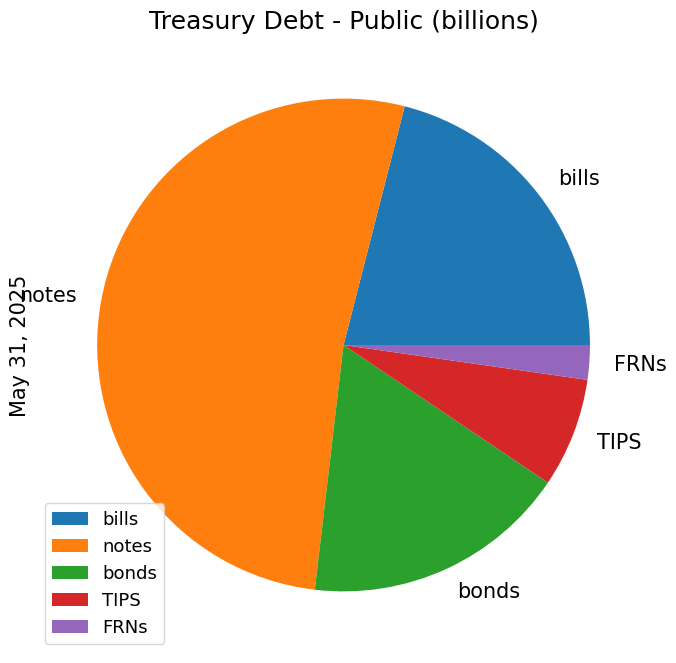

In [6]:
debt_outstanding = pd.DataFrame(index=['bills','notes','bonds','TIPS','FRNs'],data=[6002.4,14893.0,4978.5,2049.0,646.3],columns=['public debt (billions)'])
debt_outstanding.plot.pie(y=debt_outstanding.columns[0],figsize=(8,8),title='Treasury Debt - Public (billions)',ylabel='May 31, 2025')
plt.show()

# Dealers

Treasuries are bought by auction or in secondary markets.
* Primary dealers buy most new issues at auction and sell them all over the world.
* The New York Fed publishes a list of these dealers, along with a “Weekly Release of Primary Dealer Transactions”.
* Include Citigroup, Deutsche Bank, Morgan Stanley, Nomura, UBS.
* Recent additions or removals?

# Pricing

Price is quoted per $100 face value

### Par
A bond trading above face value is said to trade above par
#### Bonds with coupons larger than current interest rates will trade above par.
* Trade above par: coupons are large enough to more than offset the present value discount.


### Pricing function
The only features of an issue impacting price would be
* remaining maturity: $T-t$
* coupon rate

In a **frictionless market**, the 
* issue date would be irrelevant to the price.
* fresh 5-year note and 10-year note issued 5 years ago would have same price if same coupon rate.

But there are frictions and liquidity issues
* **on-the-run** bonds are the fresh (recent) issue and tend to have more liquidity and thus higher price.

### Bid-Ask Spread
The data set quotes a `bid` and `ask`.
* **Bid** is the price offered by a potential buyer
* **Ask** is the price offered by a potential seller
* For most issues, these are very close.

In [7]:
data['ask-bid'] = data['ask'] - data['bid']
tab = data[['type','issue date', 'maturity date', 'ttm', 'cpn rate', 'ytm', 'price', 'ask-bid']].sort_values('ask-bid')

tab_style = tab.head().style.format({'ytm':"{:.2%}",'price':"{:.2f}",'ask-bid':"{:.4f}",'cpn rate':"{:.2f}",'ttm':"{:.2f}",'maturity date':"{:%Y-%m-%d}",'issue date':"{:%Y-%m-%d}"})
display(tab_style)

tab_style = tab.tail().style.format({'ytm':"{:.2%}",'price':"{:.2f}",'ask-bid':"{:.4f}",'cpn rate':"{:.2f}",'ttm':"{:.2f}",'maturity date':"{:%Y-%m-%d}",'issue date':"{:%Y-%m-%d}"})
display(tab_style)

display(data[['ask-bid']].describe().T.style.format("{:.2f}"))

,type,issue date,maturity date,ttm,cpn rate,ytm,price,ask-bid
KYTREASNO,,,,,,,,
208162,bill,2024-01-09,2024-05-07,0.02,0.00,5.55%,99.90,0.0002
208127,bill,2023-11-02,2024-05-02,0.01,0.00,5.38%,99.97,0.0004
208163,bill,2024-01-16,2024-05-14,0.04,0.00,5.44%,99.79,0.0004
208141,bill,2023-12-07,2024-06-06,0.10,0.00,5.44%,99.46,0.0005
208164,bill,2024-01-23,2024-05-21,0.06,0.00,5.41%,99.69,0.0006


,type,issue date,maturity date,ttm,cpn rate,ytm,price,ask-bid
KYTREASNO,,,,,,,,
207068,TIPS note,2017-02-15,2047-02-15,22.80,0.88,nan%,72.55,0.2109
207188,TIPS note,2018-02-15,2048-02-15,23.79,1.00,nan%,73.97,0.2188
207327,TIPS note,2019-02-15,2049-02-15,24.80,1.00,nan%,73.35,0.2227
208020,TIPS note,2023-02-15,2053-02-15,28.80,1.50,nan%,81.10,0.2617
208191,TIPS note,2024-02-15,2054-02-15,29.80,2.12,nan%,94.00,0.2969


,count,mean,std,min,25%,50%,75%,max
ask-bid,443.00,0.04,0.04,0.00,0.02,0.03,0.05,0.30


## On-the-run

Suppose you are interested in investing in a treasury with 5 years until maturity.

Consider two alternatives:
* buy a newly issued 5-year note
* buy a 10-year note that was issued 5 years ago

The newly issued note is **on-the-run**.

A treasury which has aged is **off-the-run**.

This is an important consideration in liquidity.
* financial intermediaries have substantial business in selling the on-the-run while hedging with the off-the-run.
* in some sense, this is trading on liquidity.

In [18]:
temp = data[data['ttm'].between(5.9,6.1)].dropna()

earliest_date_index = temp['issue date'].idxmin()
latest_date_index = temp['issue date'].idxmax()
earliest_date_row = temp.loc[earliest_date_index]
latest_date_row = temp.loc[latest_date_index]

tab = pd.DataFrame([earliest_date_row, latest_date_row])

tab[['type','quote date','issue date','maturity date','ttm','cpn rate','price','ytm','public size']].style.format(
    {'ytm':'{:.3%}',
    'issue date': '{:%Y-%m-%d}', 
    'quote date': '{:%Y-%m-%d}', 
    'maturity date': '{:%Y-%m-%d}',                                                                                                                             
    'price':'{:.2f}', 
    'cpn rate':'{:.2f}', 
    'ttm':'{:.2f}', 
    'ask-bid':'{:.2f}',
    'public size':'{:.1e}'
    })

,type,quote date,issue date,maturity date,ttm,cpn rate,price,ytm,public size
204096,bond,2024-04-30,1999-11-15,2030-05-15,6.04,6.25,107.90,4.732%,6.4e+09
208059,note,2024-04-30,2023-05-31,2030-05-31,6.08,3.75,94.89,4.726%,3.5e+10


## Quoting Conventions 

Bonds differ in maturity and coupons, so looking at their relative prices is an apple-to-oranges comparison.

**Yields** are a form of price quote that accounts for the maturity and coupon.

### YTM 

The YTM discussed above is the most important yield. 
* It is used in **quoting** and **analyzing** bonds.
* The YTM is not necessarily a sufficient statistics for all dimensions of a bond--price, coupon, maturity. Thus, two with equivalent YTM may have important differences.

### Discount yield
The discount yield is important for quoting money-market prices.
* it is not popular for analyzing and research
* it is perhaps vestigial to a time when traders needed to calculate by hand and calculator

**Treasury bills** are typically quoted as discount yields.

Consider
* price of $P$
* face value of 100
* no coupon

Then,
$$\text{discount yield} = \left(\frac{360}{n}\right)\frac{100-P}{100}$$

#### Example

A T-bill maturing in 90 days with cash price of $P=99$ will have discount yield of 
$$Y_{\text{discount}} = 4\%$$

Note that it will be common to go the other way around: read quotes for 90-day T-bills of 4\% (or simply, "4") and understand that as an actual price of 99.


<img src='../refs/treasury_quotes_bills_2024_front.png'>

<img src='../refs/treasury_quotes_bills_2024_back.png'>

Reference: Bloomberg `B Govt`

## Price Quotes

T-notes and T-bonds are quoted in thirty-seconds (1/32) of a dollar rather than hundredths of a dollar.

<img src='../refs/treasury_quotes_bonds_notes_2024_front.png'>

<img src='../refs/treasury_quotes_bonds_notes_2024_back.png'>

Reference: Bloomberg `T Govt`

## Accrued Interest

Accrued interest is proportional to the coupon rate, based on the number of days since the last coupon (or, until the next coupon.)

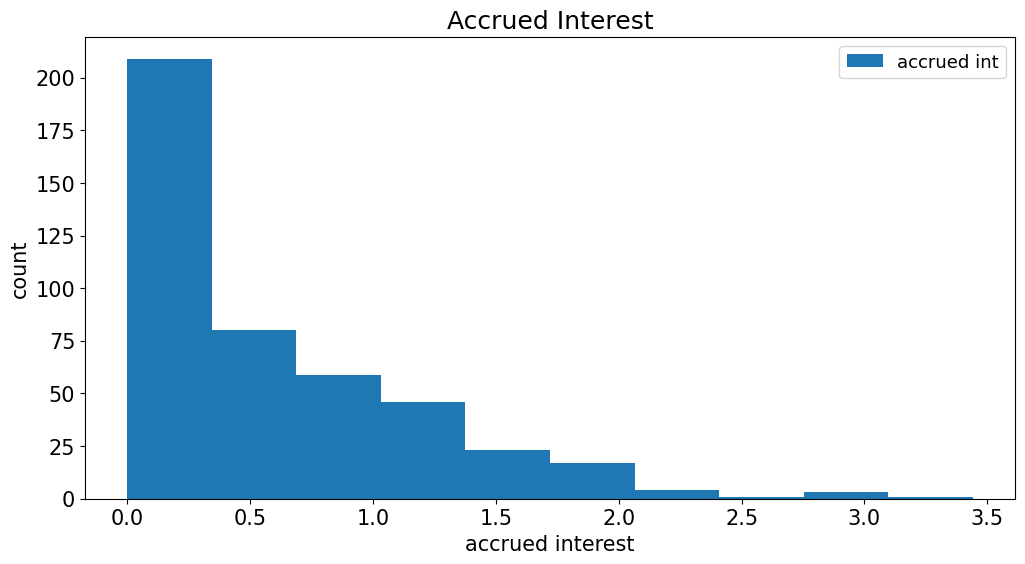

In [9]:
data[['accrued int']].plot.hist(title='Accrued Interest',xlabel='accrued interest',ylabel='count');

### Day-Count Conventions

The accrued interest is computed with a day-count convention

$$\text{accrued interest} = \frac{\text{days counted}}{\text{days in reference period}} \times \text{interest in reference period}$$

Common day-count conventions include:
* actual/actual: treasury notes and bonds
* 30/360: corporate and municipal bonds
* actual/360: money-market instruments (issued with 1yr or less, little credit risk)

Careful, or can lead to seeming arbitrage that doesn't exist.

We will not focus on the taxonomy of day-count conventions in discussions below.
* important to know what it is
* look it up when necessary

***

# Market Sizes

## Size of Treasury Debt Markets
https://fred.stlouisfed.org/series/GFDEBTN

### Composition of Treasury Debt
Monthly Statement of the Public Debt

https://fiscaldata.treasury.gov/datasets/monthly-statement-public-debt/summary-of-treasury-securities-outstanding

STRIPS

https://fiscaldata.treasury.gov/datasets/monthly-statement-public-debt/holdings-of-treasury-securities-in-stripped-form


## Size of Fixed Income Markets
https://www.sifma.org/resources/research/us-fixed-income-securities-statistics/